# Clustering

*  We are going to read graph from the given movie_actor_network.csv This is a bipartite graph data.

*  Using stellergaph and gensim packages, we are going to get the dense representation(128dimensional vector) of every node in the graph.

* Split the dense representation into actor nodes, movies nodes


# Part 1 : Applying clustering algorithm to group similar actors

1. For this task consider only the actor nodes 
2. Apply a clustering algorithm of our choice <br>
3. Choose the number of clusters for which we have maximum score of <b>$Cost1*Cost2$</b><br>
4. Cost1 = $\frac{1}{N}\sum_{\text{each cluster i}}  \frac{\text{(number of nodes in the largest connected component in the graph with the actor nodes and its movie neighbours in cluster i)}}{\text{(total number of nodes in that cluster i)}}$ where N= number of clusters 
<br> <br>
5. Cost2 = $\frac{1}{N}\sum_{\text{each cluster i}}  \frac{\text{(sum of degress of actor nodes in the graph with the actor nodes and its movie neighbours in cluster i)}}{\text{(number of unique movie nodes in the graph with the actor nodes and its movie neighbours in cluster i)}}$ where N= number of clusters 
 
6. Fit the clustering algorithm with the opimal number_of_clusters and get the cluster number for each node <br>
7. Convert the d-dimensional dense vectors of nodes into 2-dimensional using dimensionality reduction techniques (preferably TSNE)<br>
8. Plot the 2d scatter plot, with the node vectors after step e and give colors to nodes such that same cluster nodes will have same color.

<img src='https://i.imgur.com/4SPYPFa.jpg'>
<br>
<strong>Credits : AppliedAI</strong>

# Part 2 : Apply clustering algorithm to group similar movies


1. For this task we will consider only the movie nodes
2. We will apply any clustering algorithm of your choice
3. We have to choose the number of clusters for which you have maximum score of $Cost1*Cost2$ <br>

    Cost1 = $\frac{1}{N}\sum_{\text{each cluster i}}  \frac{\text{(number of nodes in the largest connected component in the graph with the movie nodes and its actor neighbours in cluster i)}}{\text{(total number of nodes in that cluster i)}}$ where N= number of clusters
	
4. Cost2 = $\frac{1}{N}\sum_{\text{each cluster i}}  \frac{\text{(sum of degress of movie nodes in the graph with the movie nodes and its actor neighbours in cluster i)}}{\text{(number of unique actor nodes in the graph with the movie nodes and its actor neighbours in cluster i)}}$ 
<br>where N= number of clusters 


**Algorithm for actor nodes**

<pre>
	for number_of_clusters in [3, 5, 10, 30, 50, 100, 200, 500]:
		algo = clustering_algorith(clusters=number_of_clusters)
        # we will be passing a matrix of size N*d where N number of actor nodes and d is dimension from gensim
		algo.fit(the dense vectors of actor nodes) 
        We can get the labels for corresponding actor nodes (algo.labels_)
        Create a graph for every cluster(ie., if n_clusters=3, create 3 graphs)
        (We can use ego_graph to create subgraph from the actual graph)
        compute cost1,cost2 
           (if n_cluster=3, cost1=cost1(graph1)+cost1(graph2)+cost1(graph3) # here we are doing summation
            cost2=cost2(graph1)+cost2(graph2)+cost2(graph3)
		computer the metric Cost = Cost1*Cost2
	return number_of_clusters which have maximum Cost
	</pre>

# Importing libraries

In [ ]:
!pip install networkx==2.3
!pip install stellarGraph

In [ ]:
import networkx as nx
from networkx.algorithms import bipartite
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import numpy as np
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
from sklearn.cluster import KMeans 
from sklearn.manifold import TSNE
from tqdm import tqdm

# you need to have tensorflow 
from stellargraph.data import UniformRandomMetaPathWalk
from stellargraph import StellarGraph

# Download and Read the data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
location = '/content/drive/MyDrive/AAIC_Assignments/12_Clustering_on_Graph_Dataset/movie_actor_network.csv'

Mounted at /content/drive


In [ ]:
data=pd.read_csv(location, index_col=False, names=['movie','actor'])
data.head()

,movie,actor
0,m1,a1
1,m2,a1
2,m2,a2
3,m3,a1
4,m3,a3


# Store the edges and create a graph

In [ ]:
# Store the edges in a list
edges = [tuple(x) for x in data.values.tolist()]

In [ ]:
B = nx.Graph()
# Add all the nodes first and then the edges
B.add_nodes_from(data['movie'].unique(), bipartite=0, label='movie')
B.add_nodes_from(data['actor'].unique(), bipartite=1, label='actor')

B.add_edges_from(edges, label='acted')


In [ ]:
# Store the connected components of a graph
A = list(nx.connected_component_subgraphs(B))[0]

In [ ]:
print("number of nodes", A.number_of_nodes())
print("number of edges", A.number_of_edges())

number of nodes 4703
number of edges 9650


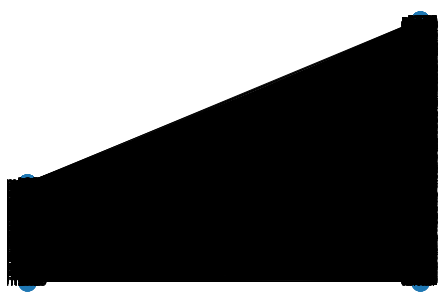

In [ ]:
# Plotting our bipartite graph
l, r = nx.bipartite.sets(A)
pos = {}

pos.update((node, (1, index)) for index, node in enumerate(l))
pos.update((node, (2, index)) for index, node in enumerate(r))
  
nx.draw(A, pos=pos, with_labels=True)
plt.show()

In [ ]:
# Separate all the actor and movie nodes
movies = []
actors = []
for i in A.nodes():
    if 'm' in i:
        movies.append(i)
    if 'a' in i:
        actors.append(i)
print('number of movies ', len(movies))
print('number of actors ', len(actors))

number of movies  1292
number of actors  3411


## Featurize the data

In [ ]:
# ****************************************** Featurizing our data ******************************************
# Create the random walker
rw = UniformRandomMetaPathWalk(StellarGraph(A))

# specify the metapath schemas as a list of lists of node types.
metapaths = [
    ["movie", "actor", "movie"],
    ["actor", "movie", "actor"]
]

walks = rw.run(nodes=list(A.nodes()), # root nodes
               length=100,  # maximum length of a random walk
               n=1,        # number of random walks per root node 
               metapaths=metapaths
              )

print(f"Number of random walks: {len(walks)}")

Number of random walks: 4703


In [ ]:
from gensim.models import Word2Vec
model = Word2Vec(walks, size=128, window=5)

In [ ]:
model.wv.vectors.shape  # 128-dimensional vector for each node in the graph

(4703, 128)

In [ ]:
# Retrieve node embeddings and corresponding subjects
node_ids = model.wv.index2word  # list of node IDs
node_embeddings = model.wv.vectors  # numpy.ndarray of size number of nodes times embeddings dimensionality
node_targets = [ A.node[node_id]['label'] for node_id in node_ids]

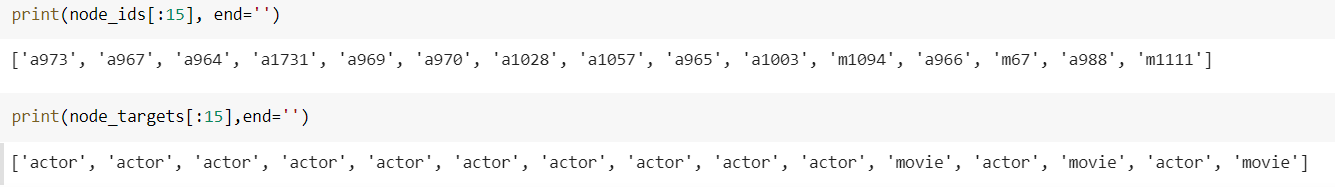

In [ ]:
node_embeddings[0].shape

(128,)

## Split the data

In [ ]:
def data_split(node_ids,node_targets,node_embeddings):
    '''In this function, we will split the node embeddings into actor_embeddings , movie_embeddings '''
    actor_nodes,movie_nodes=[],[]
    actor_embeddings,movie_embeddings=[],[]
    # split the node_embeddings into actor_embeddings,movie_embeddings based on node_ids
    # By using node_embedding and node_targets, we can extract actor_embedding and movie embedding
    # By using node_ids and node_targets, we can extract actor_nodes and movie nodes

    for i in range(len(node_ids)):
      if node_targets[i] == 'movie':
        movie_nodes.append(node_ids[i])
        movie_embeddings.append(node_embeddings[i])
      else:
        actor_nodes.append(node_ids[i])
        actor_embeddings.append(node_embeddings[i])

    
    nreturn actor_nodes,movie_nodes,actor_embeddings,movie_embeddings



In [ ]:
# Splitting the data here for the grader functions
actor_nodes,movie_nodes,actor_embeddings,movie_embeddings = data_split(node_ids,node_targets,node_embeddings)

In [ ]:
def grader_movies(data):
    assert(len(data)==1292)
    return True
grader_movies(movie_nodes)

True

### Calculating cost1

Cost1 = $\frac{1}{N}\sum_{\text{each cluster i}}  \frac{\text{(number of nodes in the largest connected component in the graph with the actor nodes and its movie neighbours in cluster i)}}{\text{(total number of nodes in that cluster i)}}$ where N= number of clusters <br><br>
<br>

In [ ]:
def cost1(graph,number_of_clusters, label='a'):
    '''
    In this function, we will calculate cost1 based on the label provided.
    Default its set to 'a' meaning that the cost1 will be calculated wrt to actor nodes.
    If we want to calculate the cost2 function for the movie nodes we'll have to pass label='m' 
    '''
    
    # Cost 1 is defined as:
      # find the connected components first. Then find the maximum of degrees of the connected components 
      # find nodes in the largest connected component
    num_nodes = len(graph.nodes)
    # find all the connected components first
    degrees = dict(graph.degree)
    max_degree = []

    for node, degree in degrees.items():
      if label in node:
        max_degree.append(degree)
    max_degree = max(max_degree) + 1    # +1 is to include the node itself

    cost1 = (max_degree)/(num_nodes * number_of_clusters)

    return cost1

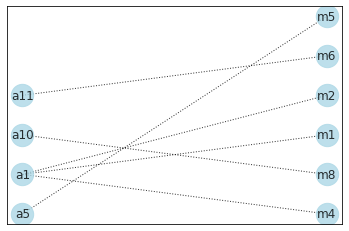

In [ ]:
import networkx as nx
from networkx.algorithms import bipartite
graded_graph= nx.Graph()
graded_graph.add_nodes_from(['a1','a5','a10','a11'], bipartite=0) # Add the node attribute "bipartite"
graded_graph.add_nodes_from(['m1','m2','m4','m6','m5','m8'], bipartite=1)
graded_graph.add_edges_from([('a1','m1'),('a1','m2'),('a1','m4'),('a11','m6'),('a5','m5'),('a10','m8')])
l={'a1','a5','a10','a11'};r={'m1','m2','m4','m6','m5','m8'}
pos = {}
pos.update((node, (1, index)) for index, node in enumerate(l))
pos.update((node, (2, index)) for index, node in enumerate(r))
nx.draw_networkx(graded_graph, pos=pos, with_labels=True,node_color='lightblue',alpha=0.8,style='dotted',node_size=500)

<font color='cyan'>Grader function - 3</font>

In [ ]:
graded_cost1=cost1(graded_graph,3)
def grader_cost1(data):
    assert(data==((1/3)*(4/10))) # 1/3 is number of clusters
    return True
grader_cost1(graded_cost1)

True

### Calculating Cost2

Cost2 = $\frac{1}{N}\sum_{\text{each cluster i}}  \frac{\text{(sum of degress of actor nodes in the graph with the actor nodes and its movie neighbours in cluster i)}}{\text{(number of unique movie nodes in the graph with the actor nodes and its movie neighbours in cluster i)}}$ where N= number of clusters 

In [ ]:
def cost2(graph,number_of_clusters, label='a'):
    '''
    In this function, we will calculate cost2 based on the label provided.
    Default its set to 'a' meaning that the cost 2 will be calculated wrt to actor nodes.
    If we want to calculate the cost function for the movie nodes we'll have to pass label='m'
    '''

    # Store all the degrees first and then iterate over all the actore nodes and sum up their degrees
    degrees = dict(graph.degree)
    sum_degree = 0              # To sum up all the degrees of all the nodes for whichever label we're doing clustering
    num_nodes = set()     # To keep track of the nodes for the denominator
    for node, degree in degrees.items():
      if label in node:
        sum_degree += degree
      else:
        num_nodes.add(node)
    
    num_nodes = len(num_nodes)
    cost2 = (sum_degree)/(num_nodes * number_of_clusters)
    
    return cost2

In [ ]:
actor_nodes,movie_nodes,actor_embeddings,movie_embeddings = data_split(node_ids,node_targets,node_embeddings)

# <font color='lightgreen'>Grouping/Clustering similar actors</font>

In [ ]:
# actor_nodes,actor_embeddings
costs = {'K':[], 'cost':[]}
for number_of_cluster in tqdm([3, 5, 10, 30, 50, 100, 200, 500]):
  
    # Iniitialize KMeans with the required parameters
    kmeans = KMeans(n_clusters=number_of_cluster,random_state=65)
    kmeans.fit(actor_embeddings)        # Fit the actor_embeddings data

    # Now we need to find the cluster labels for each actor_embedding data
    labels = kmeans.labels_
    # Now based on the labels we need to create ego_graphs

    # create a dictionary to store the all the actor nodes as per their cluster
    # keys = Cluster number; value=list containing all the actor nodes in that cluster
    clusters_dict = {x:[] for x in set(labels)}

    # Now we'll separate all the clusters and their elements
    for l, a in zip(labels,actor_nodes ):
        # Add all the actor nodes in its corresponding cluster list
        clusters_dict[l].append(a)

    # having obtained the clusters and its corresponding list of actor nodes, 
    # Now we'll have to create the graph for the actor nodes in each cluster and calculate the cost for each cluster and add them up

    # Graph creation for each cluster.
    # For this we need to filter the actor nodes from the original data
    # This can be done using the subgraph concept

    cost1_ , cost2_ = 0, 0
    for l,a in clusters_dict.items():
        # Create a graph for each cluster
        G=nx.Graph()
        # Now for each actor node we need to have its graph and add it from the main graph(A)
        for node_ in list(a):
          # print(node_)
          sub_graph=nx.ego_graph(A,node_)         # Obtain the subgraph from A for the node
          G.add_nodes_from(sub_graph.nodes)       # adding nodes to the cluster i's graph
          G.add_edges_from(sub_graph.edges())     # adding edges to it

        # after the graph is ready we can directly calculate the cost1 and cost 2 and sum it up for each cluster
        cost1_ += cost1(G,number_of_cluster,label='a')
        cost2_ += cost2(G,number_of_cluster,label='a')

    # Now Calculate the final cost nad append the cost and the corresponding cluster_number
    costs['K'].append(number_of_cluster)
    costs['cost'].append(cost1_ * cost2_)


100%|██████████| 8/8 [00:48<00:00,  6.09s/it]


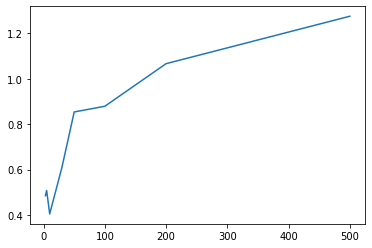

In [ ]:
plt.plot(costs['K'], costs['cost'])

In [ ]:
optimal_K = costs['K'][np.argmax(costs['cost'])]
optimal_K

500

In [ ]:
# Fit KMeans with the optimal no. of clusters
kmeans = KMeans(n_clusters=optimal_K)
kmeans.fit(actor_embeddings)        # Fit the actor_embeddings data

# Now we need to find the cluster labels for each actor_embedding data
labels = kmeans.labels_

# So now that we have the labels, actor nodes and theri corresponding actor embeddings were going to use TSNE to vizualize the same
# We'll use the labels as the colours themselves 

<font color='lightblue'>Displaying similar actor clusters</font>

In [ ]:
transform = TSNE #PCA

trans = transform(n_components=2)
node_embeddings_2d = trans.fit_transform(actor_embeddings)


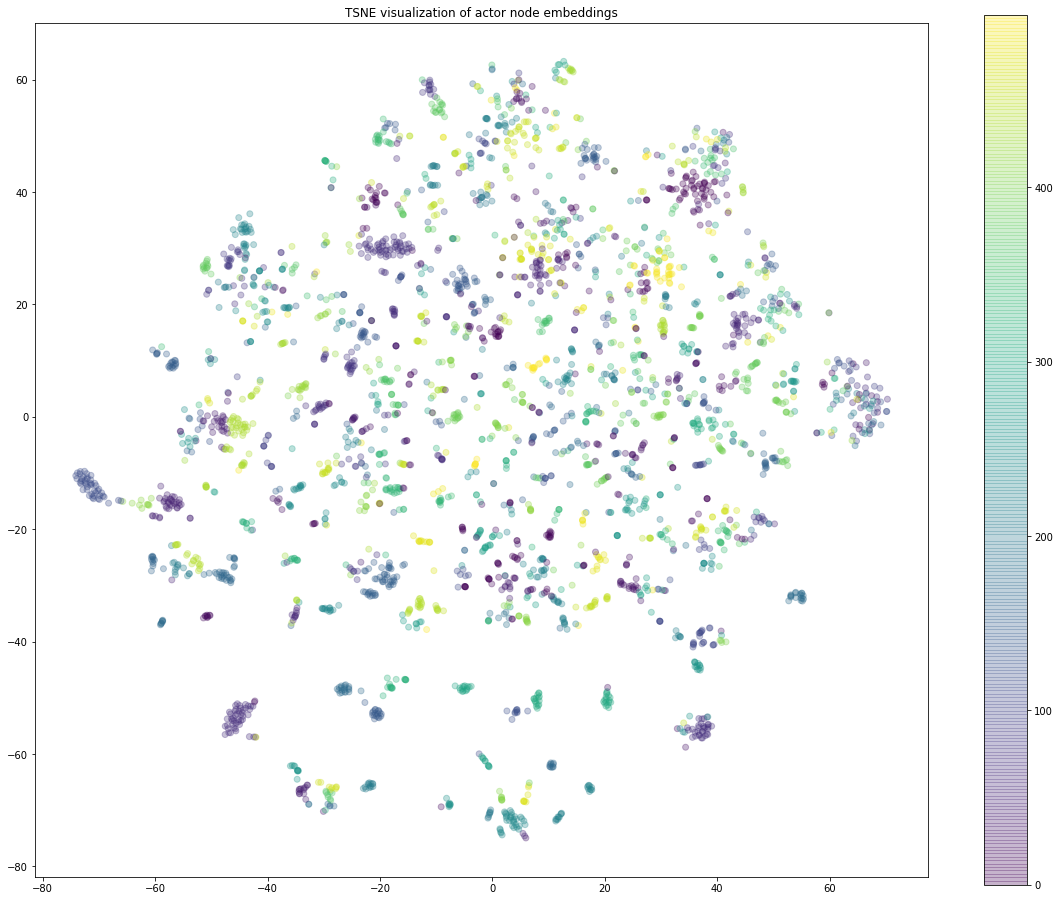

In [ ]:
plt.figure(figsize=(20,16))
plt.axes().set(aspect="equal")
plt.scatter(node_embeddings_2d[:,0], 
            node_embeddings_2d[:,1], 
            c=labels, alpha=0.3)
plt.title('{} visualization of actor node embeddings'.format(transform.__name__))
plt.colorbar()

plt.show()

# <font color='lightgreen'>Grouping similar movies</font>

In [ ]:
# movie_nodes,movie_embeddings
costs = {'K':[], 'cost':[]}
for number_of_cluster in tqdm([3, 5, 10, 30, 50, 100, 200, 500]):
  
    # Iniitialize KMeans with the required parameters
    kmeans = KMeans(n_clusters=number_of_cluster, random_state=65)
    kmeans.fit(movie_embeddings)        # Fit the movie_embeddings data

    # Now we need to find the cluster labels for each movie_embedding data
    labels = kmeans.labels_
    # Now based on the labels we need to create ego_graphs

    # create a dictionary to store the all the actor nodes as per their cluster
    # keys = Cluster number; value=list containing all the movie nodes in that cluster
    clusters_dict = {x:[] for x in set(labels)}

    # Now we'll separate all the clusters and their elements
    for l, a in zip(labels,movie_nodes ):
      # Add all the movie nodes in its corresponding cluster list
      clusters_dict[l].append(a)

    # having obtained the clusters and its corresponding list of movie nodes, 
    # Now we'll have to create the graph for the movie nodes in each cluster and calculate the cost for each cluster and add them up

    # Graph creation for each cluster.
    # For this we need to filter the movie nodes from the original data
    # This can be done using the subgraph concept

    cost1_ , cost2_ = 0, 0
    for l,a in clusters_dict.items():
      # Create a graph for each cluster
      G=nx.Graph()
      # Now for each movie node we need to have its graph and add it from the main graph(A)
      for node_ in list(a):
        # print(node_)
        sub_graph=nx.ego_graph(A,node_)         # Obtain the subgraph from A for the node
        G.add_nodes_from(sub_graph.nodes)       # adding nodes to the cluster i's graph
        G.add_edges_from(sub_graph.edges())     # adding edges to it

      # after the graph is ready we can directly calculate the cost1 and cost 2 and sum it up for each cluster
      cost1_ += cost1(G,number_of_cluster,label='m')
      cost2_ += cost2(G,number_of_cluster,label='m')

    # Now Calculate the final cost nad append the cost and the corresponding cluster_number
    costs['K'].append(number_of_cluster)
    costs['cost'].append(cost1_ * cost2_)


100%|██████████| 8/8 [00:25<00:00,  3.22s/it]


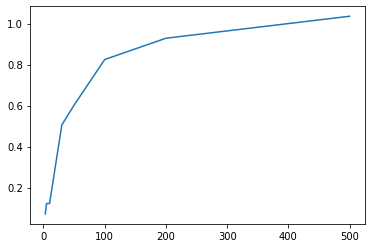

In [ ]:
plt.plot(costs['K'], costs['cost'])

In [ ]:
optimal_K_movies = costs['K'][np.argmax(costs['cost'])]
optimal_K_movies

500

In [ ]:
# Fit KMeans with the optimal no. of clusters
kmeans = KMeans(n_clusters=optimal_K_movies)
kmeans.fit(movie_embeddings)        # Fit the actor_embeddings data

# Now we need to find the cluster labels for each movie_embedding data
labels_movies = kmeans.labels_

# So now that we have the labels, movie nodes and their corresponding movie embeddings were going to use TSNE to vizualize the same
# We'll use the labels as the colours themselves 

<font color='lightblue'>Displaying similar movie clusters</font>

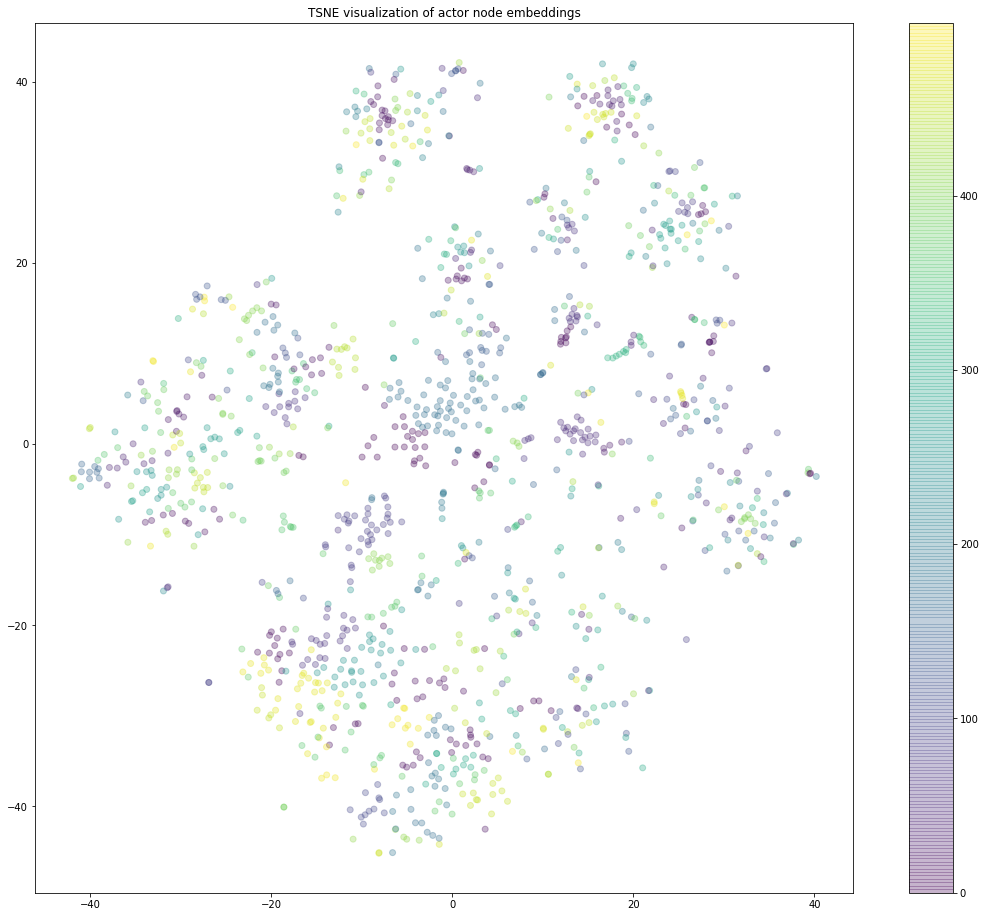

In [ ]:
transform = TSNE #PCA

trans = transform(n_components=2)
node_embeddings_2d = trans.fit_transform(movie_embeddings)

plt.figure(figsize=(20,16))
plt.axes().set(aspect="equal")
plt.scatter(node_embeddings_2d[:,0], 
            node_embeddings_2d[:,1], 
            c=labels_movies, alpha=0.3)
plt.title('{} visualization of actor node embeddings'.format(transform.__name__))
plt.colorbar()

plt.show()